# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [2]:
# Autograd & Numpy Ceci est un test 
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

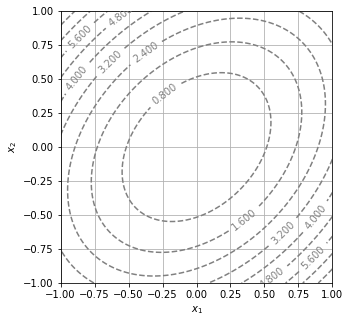

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [10]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

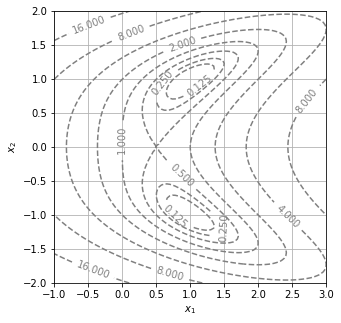

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

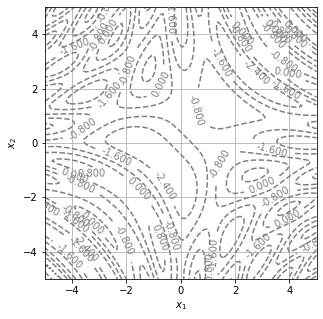

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [14]:
N = 100
eps = 0.001

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(F, x0, y0, eps=eps, N=N):
    for i in range(N):
        J_F = J(F)(x0, y0)
        B = J_F.dot(np.array([x0, y0])) - F(x0, y0)
        sol = np.linalg.solve(J_F, B)
        x = sol[0]
        y = sol[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

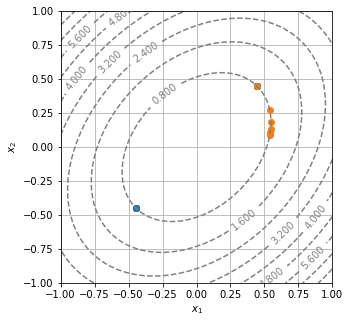

In [16]:
def fonction_test(x, y):
    return np.array([f1(x, y) - 0.8, x - y])

test_list = np.linspace(-0.6 , 1.2, 15)
var_pt_dep = np.empty((2, len(test_list)))

for i in range(15):
    k = test_list[i]
    x, y = Newton(fonction_test, k, k)
    var_pt_dep[0][i] = x
    var_pt_dep[1][i] = y 



var_contrainte = np.empty((2, 6))

for i in range(1, 7):
    def fonction_contrainte(x, y): 
        return np.array([f1(x,y) - 0.8, x - i * y])
    x, y = Newton(fonction_contrainte, 0.8, 0.8)
    var_contrainte[0][i-1] = x
    var_contrainte[1][i-1] = y 


display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

plt.scatter(var_pt_dep[0], var_pt_dep[1])
plt.scatter(var_contrainte[0], var_contrainte[1])
plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [17]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    table = np.empty((2, N))
    table[0][0] = x0
    table[1][0] = y0
    rotation = np.array([ [0, 1], [-1, 0]])
    c=f(x0,y0)
    for i in range (N): 
        def g(x,y):
            return np.array([f(x,y)-c, np.sqrt((x-x0)**2 + (y-y0)**2) - delta])
        grad_f = grad(f)
        g_f = grad_f(x0, y0) / np.linalg.norm(grad_f(x0, y0))
        vecteur = np.dot(g_f, rotation) * delta
        x = x0 + vecteur[0]
        y = y0 + vecteur[1]
        x0, y0 = Newton(g, x, y)
        table[0][i] = x0
        table[1][i] = y0 
    return table 

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [18]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    table = np.empty((2, N))
    table[0][0] = x0
    table[1][0] = y0
    rotation = np.array([ [0, 1], [-1, 0]])
    c=f(x0,y0)
    for i in range (N): 
        def g(x,y):
            return np.array([f(x,y)-c, np.sqrt((x-x0)**2 + (y-y0)**2) - delta])
        grad_f = grad(f)
        g_f = grad_f(x0, y0) / np.linalg.norm(grad_f(x0, y0))
        vecteur = np.dot(g_f, rotation) * delta
        x = x0 + vecteur[0]
        y = y0 + vecteur[1]
        x0, y0 = Newton(g, x, y)
        for k in range(i): 
            if (table[0][k] - x0)**2 + (table[1][k] - y0)**2 < delta**2: 
                return table[: , :i]
        table[0][i] = x0
        table[1][i] = y0  
    return table 

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

In [19]:
def fonction_test(x, y):
    return np.array([f2(x, y) - 0.5 , x - y])

L = Newton(fonction_test, 0.8, 0.8)
print(L)

(0.3281402489602854, 0.3281402489602854)


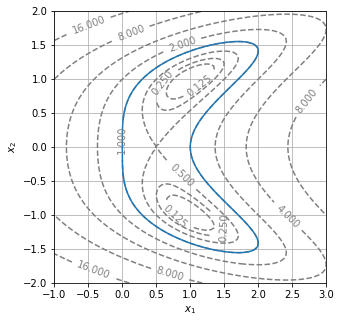

In [20]:
#Test avec f2, courbe de niveau 1 -- Pas de problème

table=level_curve(f2, -8.649502590964306e-08, -8.649502590964307e-08,0.01) #un point à f2(x,y) = 1


display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

plt.plot(table[0],table[1])

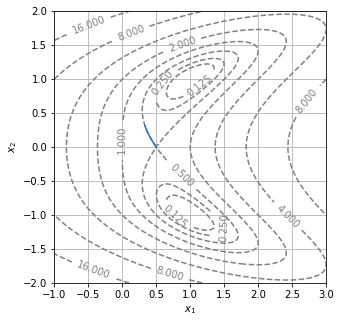

In [21]:
#Test avec f2, courbe de niveau 0.5 -- Erreur, due à l'annulation du gradient au point (0.5, 0) point d'intersection
#la méthode ne fonctionne pas si la courbe de niveau se recoupe, autrement dit si la courbe de niveau n'est pas un arc paramétré de classe C1

table=level_curve(f2, 0.3281402489602854, 0.3281402489602854 ,0.01) #un point à f2(x,y) = 0.5

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

plt.plot(table[0],table[1])

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

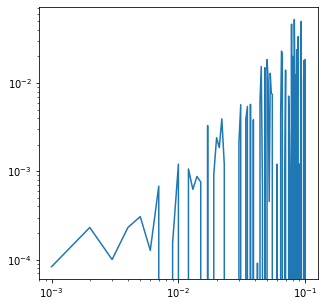

In [33]:
def area_squares(f, c, h):
    # Si on avait voulu déterminer un carré adapté
    #def f_n(x, y): 
    #    return np.array([f(x,y) - c, x - y ]) 
    #N1, N2 = Newton(f_n, 1.0, 0.0, eps, 100)
    #limite = level_curve(f, N1, N2)
    #min_abs = np.min(limite[0])
    #max_abs = np.max(limite[0])
    #min_ord = np.min(limite[1])
    #max_ord = np.max(limite[1])
    #en prenant un carré arbitraire au vu de nos exemples
    min_abs = -2.5
    max_abs = 2.5
    min_ord = -2.5
    max_ord = 2.5
    # L est la demi longueur du carré dans lequel on plonge K 
    L = max(min_abs, max_abs, min_ord, max_ord)
    N = int(2 * L / h) + 1
    s = 0 
    for j in range(N):
        for i in range(N):
            if f(min_abs + i*h + h/2, min_ord + j*h + h/2) < c :
                s += h**2
    return s 
                
def norme(x, y): 
    return np.sqrt(x**2 + y**2)

h_liste = np.linspace(0.001, 0.1, 100)
erreur = np.empty((len(h_liste, )))

for k in range(len(h_liste)) : 
    erreur[k] = area_squares(norme, 1, h_liste[k]) - np.pi 

plt.plot(h_liste, erreur)
plt.loglog(basex = 10, basey = 10)
plt.show()

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [ ]:
def better_area_squares(f, c, h): 
    def f_n(x, y): 
        return np.array([f(x,y) - c, x - y ]) 
    N1, N2 = Newton(f_n, 1.0, 0.0, eps, 100)
    limite = level_curve(f, N1, N2)
    # On cherche à déterminer la taille du carré dans lequel on plonge K 
    min_abs = np.min(limite[0])
    max_abs = np.max(limite[0])
    min_ord = np.min(limite[1])
    max_ord = np.max(limite[1])
    # L est la demi longueur du carré dans lequel on plonge K 
    L = max(max_abs - min_abs, max_ord - min_ord)
    N = int(2 * L / h) + 1 
    s_inf = 0 
    s_sup = 0 
    for j in range(N):
        for i in range(N):
            if f(min_abs + i*h + h/2, min_ord + j*h + h/2) < c :
                s_inf += h**2
                s_sup += h**2
            else : 
                table = np.array([f(min_abs + (i+1)*h + h/2, min_ord + j*h + h/2), f(min_abs + (i-1)*h + h/2, min_ord + j*h + h/2),
                                  f(min_abs + i*h + h/2, min_ord + (j+1)*h + h/2), f(min_abs + i*h + h/2, min_ord + (j-1)*h + h/2) ])
                if np.any(table < c) :
                      s_sup += h**2

    return s_inf, s_sup 

eps = 0.01
h = 0.01
s_inf, s_sup = better_area_squares(norme, 1, h)

while s_sup - s_inf > eps:
    h = h / 2
    s_inf, s_sup = better_area_squares(norme, 1, h)

print(f"L'encadrement de l'aire du disque à 10^-2 près est : {s_inf} < D < {s_sup} ")

0.052600000000111
0.026724999999937715
0.013537500000449398
L'encadrement de l'aire du disque à 10^-2 près est : 3.141515625086732 < D < 3.1483375000869587 


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

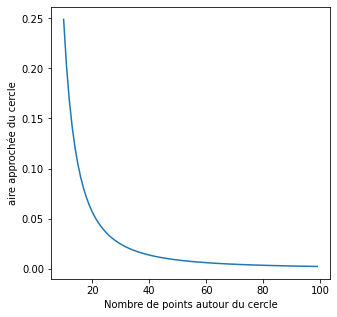

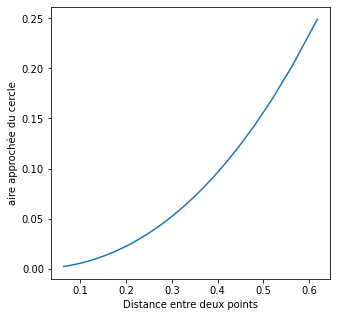

In [23]:
def aire_du_cercle(N): 
    x = np.cos(np.linspace(0, 2*np.pi, N))
    y = np.sin(np.linspace(0, 2*np.pi, N))
    cen_gra = np.array([0,0])
    s = 0
    for i in range(N-1): 
        # On calcul l'aire par méthode de héron 
        Xi = np.array([x[i], y[i]])
        Xi_1 = np.array([x[i+1], y[i+1]])
        a = np.linalg.norm(Xi - cen_gra)
        b = np.linalg.norm(Xi_1 - cen_gra)
        c = np.linalg.norm(Xi_1 - Xi)
        p = (a + c + b)/2
        s += np.sqrt(p*(p - a)*(p - b)*(p - c))
    return s 

distance = []
aire = []
pas = []

for k in range(10, 100): 
    pas.append(k)
    dis = np.sqrt( (np.sin(2*np.pi/k))**2 + (1 - np.cos(2*np.pi/k))**2)
    distance.append(dis)
    aire.append(np.pi - aire_du_cercle(k))

plt.plot(pas, aire)
plt.xlabel("Nombre de points autour du cercle")
plt.ylabel("aire approchée du cercle")
plt.show()
    
plt.plot(distance, aire)
plt.xlabel("Distance entre deux points")
plt.ylabel("aire approchée du cercle")
plt.show()

# On calcule l'erreur exacte 

# La vitesse de convergence semble donc être de exp(-1/N)


**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

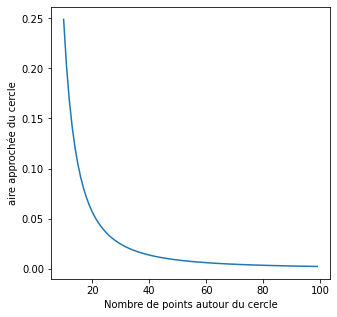

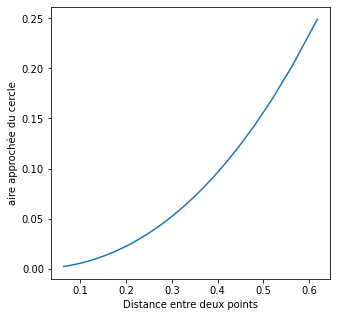

In [24]:
def aire_du_cercle_ext(N, xp, yp): 
    x = np.cos(np.linspace(0, 2*np.pi, N))
    y = np.sin(np.linspace(0, 2*np.pi, N))
    centre = np.array([xp, yp])
    s = 0
    for i in range(N-1): 
        # On calcule l'aire par méthode de héron 
        Xi = np.array([x[i], y[i]])
        Xi_1 = np.array([x[i+1], y[i+1]])
        a = np.linalg.norm(Xi - centre)
        b = np.linalg.norm(Xi_1 - centre)
        c = np.linalg.norm(Xi_1 - Xi)
        p = (a + c + b)/2
        temp = np.sqrt(p*(p - a)*(p - b)*(p - c)) * np.sign( np.linalg.det( np.array([Xi - centre, Xi_1 - centre])))
        s += temp
    return s 

distance = []
aire = []
pas = []

xp, yp = 2,3

for k in range(10, 100): 
    pas.append(k)
    dis = np.sqrt( (np.sin(2*np.pi/k))**2 + (1 - np.cos(2*np.pi/k))**2)
    distance.append(dis)
    aire.append(np.pi - aire_du_cercle_ext(k, xp, yp))

plt.plot(pas, aire)
plt.xlabel("Nombre de points autour du cercle")
plt.ylabel("aire approchée du cercle")
plt.show()
    
plt.plot(distance, aire)
plt.xlabel("Distance entre deux points")
plt.ylabel("aire approchée du cercle")
plt.show()

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

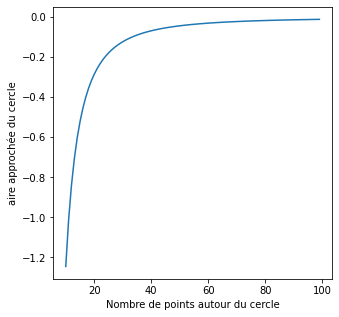

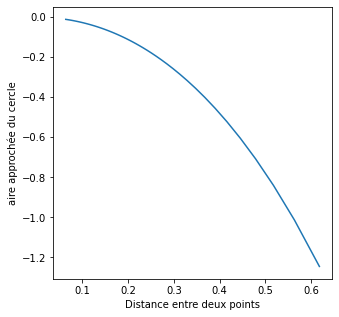

In [27]:
#Cela marche bien car le triangle ajouté par le segment non désiré de passage entre les deux disques a une aire comptée une fois négativement et une fois positivement

def genere_disque(rayon, nbpts, centre):
    return np.array([rayon * np.cos(np.linspace(0, 2*np.pi, nbpts))+centre[0], rayon * -np.sin(np.linspace(0, 2*np.pi, nbpts))+centre[1]])

def aire_K_pas_convexe(N, xp, yp): 
    x1,y1 = genere_disque(1, N, [0,0])
    x2,y2 = genere_disque(2, N, [0,4])
    x = np.concatenate([x1, x2, np.array([x1[0]])])
    y = np.concatenate([y1, y2, np.array([y1[0]])])
    N=len(x)
    centre = np.array([xp, yp])
    s = 0
    for i in range(N-1): 
        # On calcule l'aire par méthode de héron 
        Xi = np.array([x[i], y[i]])
        Xi_1 = np.array([x[i+1], y[i+1]])
        a = np.linalg.norm(Xi - centre)
        b = np.linalg.norm(Xi_1 - centre)
        c = np.linalg.norm(Xi_1 - Xi)
        p = (a + c + b)/2
        temp = np.sqrt(p*(p - a)*(p - b)*(p - c)) * np.sign( np.linalg.det( np.array([Xi_1 - centre, Xi - centre])))
        s += temp
    return s 

pas = []
aire = []
distance = []

for k in range(10, 100): 
    pas.append(k)
    dis = np.sqrt( (np.sin(2*np.pi/k))**2 + (1 - np.cos(2*np.pi/k))**2)
    distance.append(dis)
    aire.append(aire_K_pas_convexe(k, xp, yp) - 5 * np.pi)

plt.plot(pas, aire)
plt.xlabel("Nombre de points autour du cercle")
plt.ylabel("aire approchée du cercle")
plt.show()
    
plt.plot(distance, aire)
plt.xlabel("Distance entre deux points")
plt.ylabel("aire approchée du cercle")
plt.show()

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [35]:
#la fonction level_curve comptera forcément chaque segment "de liaison" deux fois (donc l'aire du triangle associé sera comptée négativement puis positivement)

def area_triangles(x, y) :
    N = len(x)
    centre = np.array([(x[0]+x[1])/2,y[0]]) #pour être sûr de pas avoir des nombres trop grands
    s = 0
    for i in range(N-1): 
        # On calcule l'aire par méthode de héron 
        Xi = np.array([x[i], y[i]])
        Xi_1 = np.array([x[i+1], y[i+1]])
        a = np.linalg.norm(Xi - centre)
        b = np.linalg.norm(Xi_1 - centre)
        c = np.linalg.norm(Xi_1 - Xi)
        p = (a + c + b)/2
        temp = np.sqrt(p*(p - a)*(p - b)*(p - c)) * np.sign( np.linalg.det( np.array([Xi - centre, Xi_1 - centre])))
        s += temp
    return s

In [38]:
#appliqué à l'ensemble des (x1,x2) tels que f2(x1, x2) <= 1 :

x, y =level_curve(f2, -8.649502590964306e-08, -8.649502590964307e-08, 0.01) #un point à f2(x,y) = 1

print("méthode des carrés : " + str(area_squares(f2, 1, 0.01)))
print("méthode des triangles : " + str(area_triangles(x, y)))


méthode des carrés : 3.6720000000033246
méthode des triangles : 3.672668007859805


Méthode carrés : 
  - complexité quadratique
  - calculs inutiles dus à la sélection non adaptée du carré de départ
  - possible d'obtenir un encadrement

Méthode triangles : 
 - complexité linéaire
 - meilleure adaptabilité
 - convergence en $\exp(-distance)$
 - impossible d'obtenir un encadrement ou une estimation précise de l'erreur